# `Занятие 5: Сегментация`

## `Задача сегментации изображений`

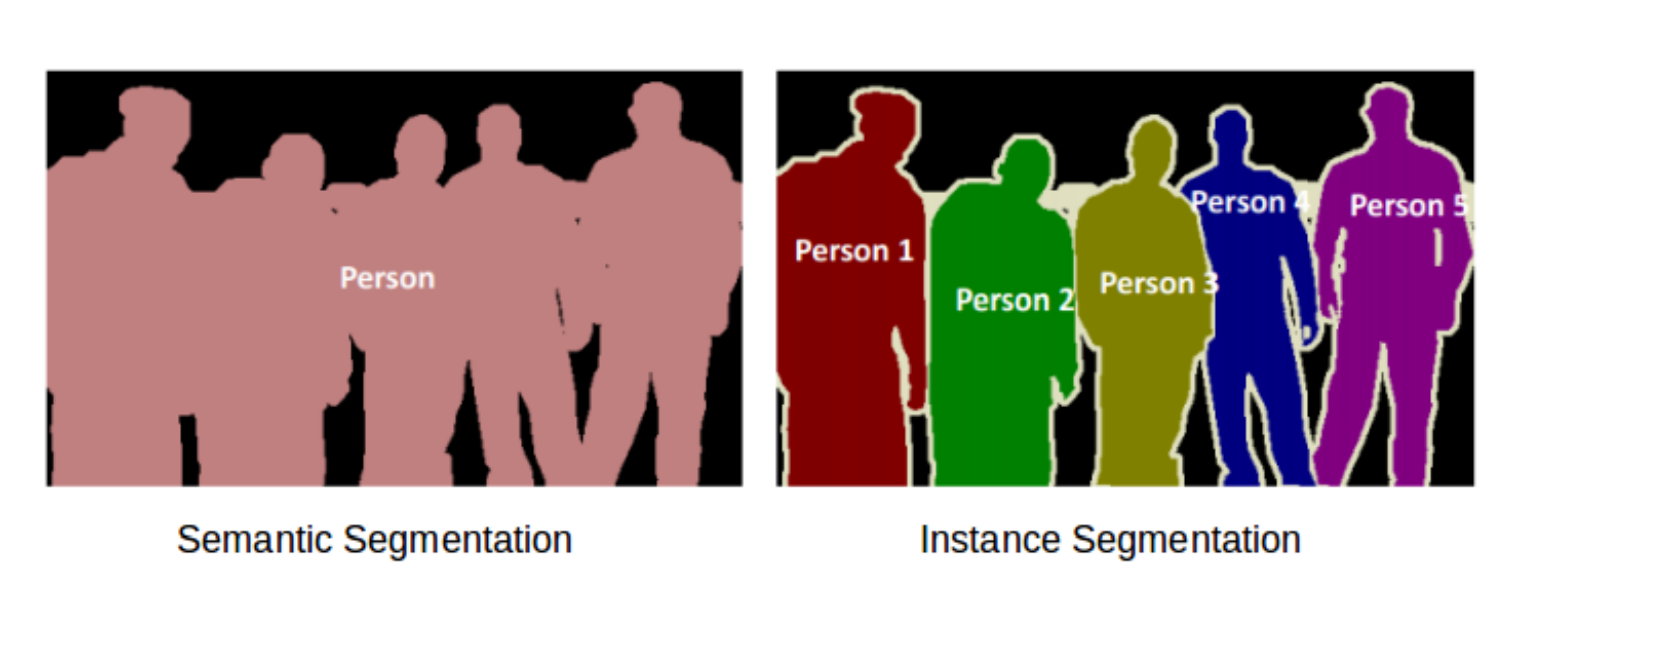

### `Классическая схема сегментационных нейронных сетей — сверточный кодировщик-декодировщик`

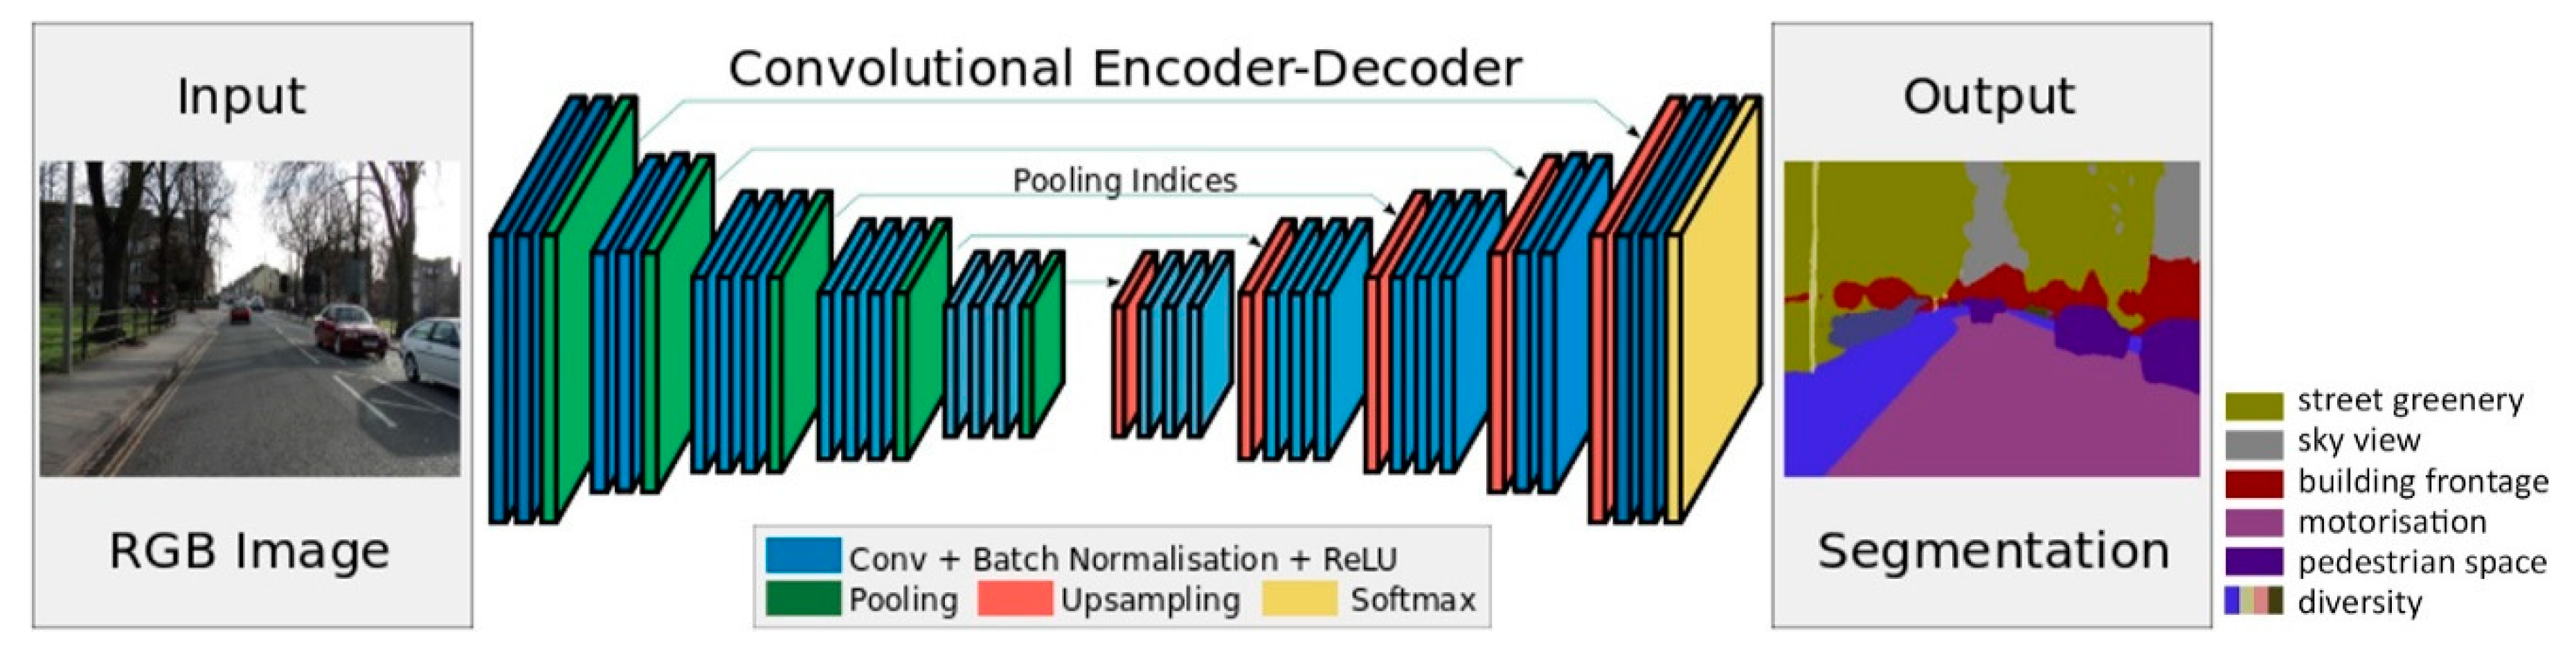

1) Проблема: ответ должен быть близок по размеру ко входу

2) Проблема: чем глубже тем лучше понимаем что изображено, но забываем контекст

3) Receptive field на последних слоях должен быть достаточно большим

## `Операции увеличения размерности:`

### `1. Upsampling`

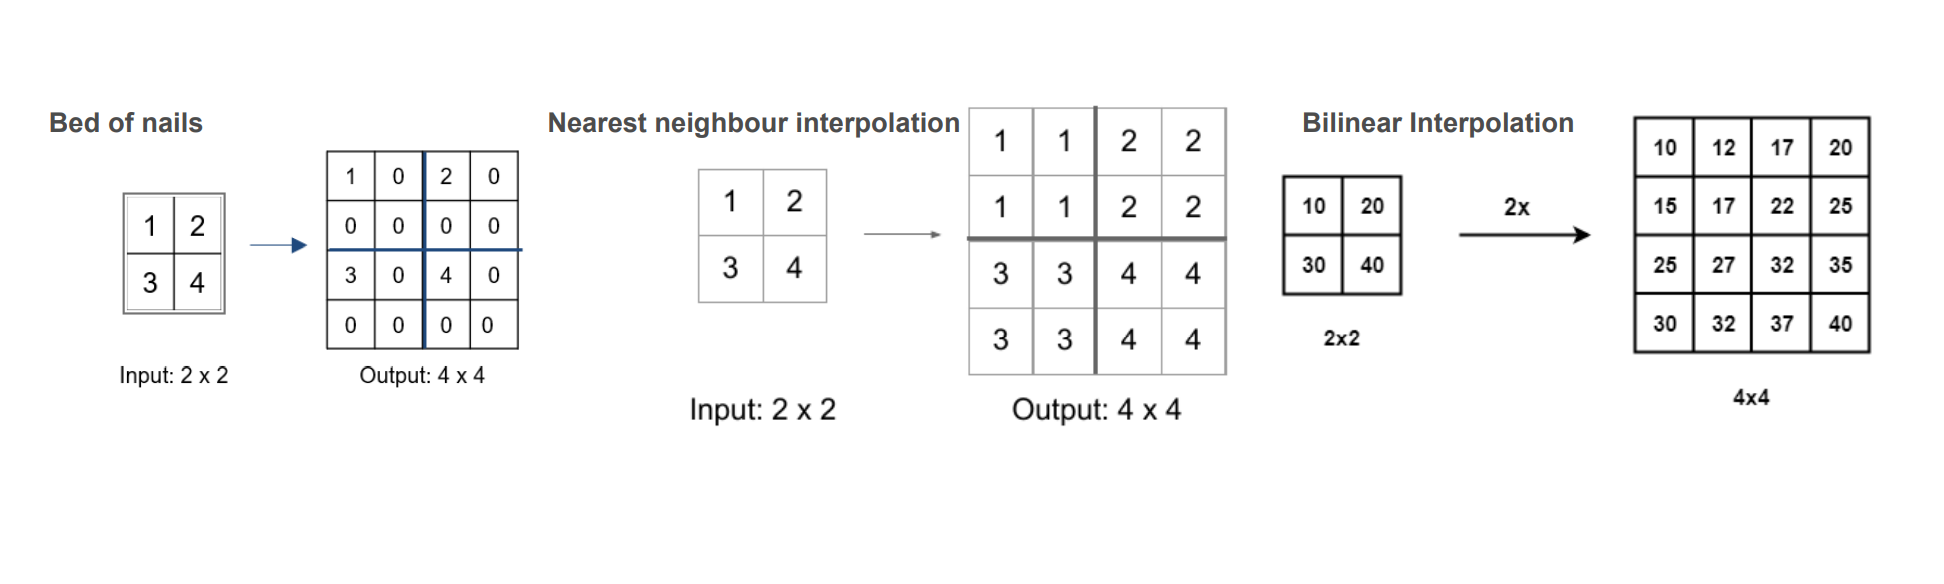

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
?torch.nn.Upsample

In [4]:
ex = torch.randint(0, 100, (2,2)).view(1, 1, 2, 2).float()
ex

tensor([[[[64., 98.],
          [59., 88.]]]])

In [5]:
ups = torch.nn.Upsample(scale_factor=(2,3), mode='nearest')
ups(ex)

tensor([[[[64., 64., 64., 98., 98., 98.],
          [64., 64., 64., 98., 98., 98.],
          [59., 59., 59., 88., 88., 88.],
          [59., 59., 59., 88., 88., 88.]]]])

In [7]:
ups = torch.nn.Upsample(scale_factor=2, mode='bilinear')
ups(ex)

tensor([[[[64.0000, 72.5000, 89.5000, 98.0000],
          [62.7500, 70.9375, 87.3125, 95.5000],
          [60.2500, 67.8125, 82.9375, 90.5000],
          [59.0000, 66.2500, 80.7500, 88.0000]]]])

### `2. Транспонированная свертка`

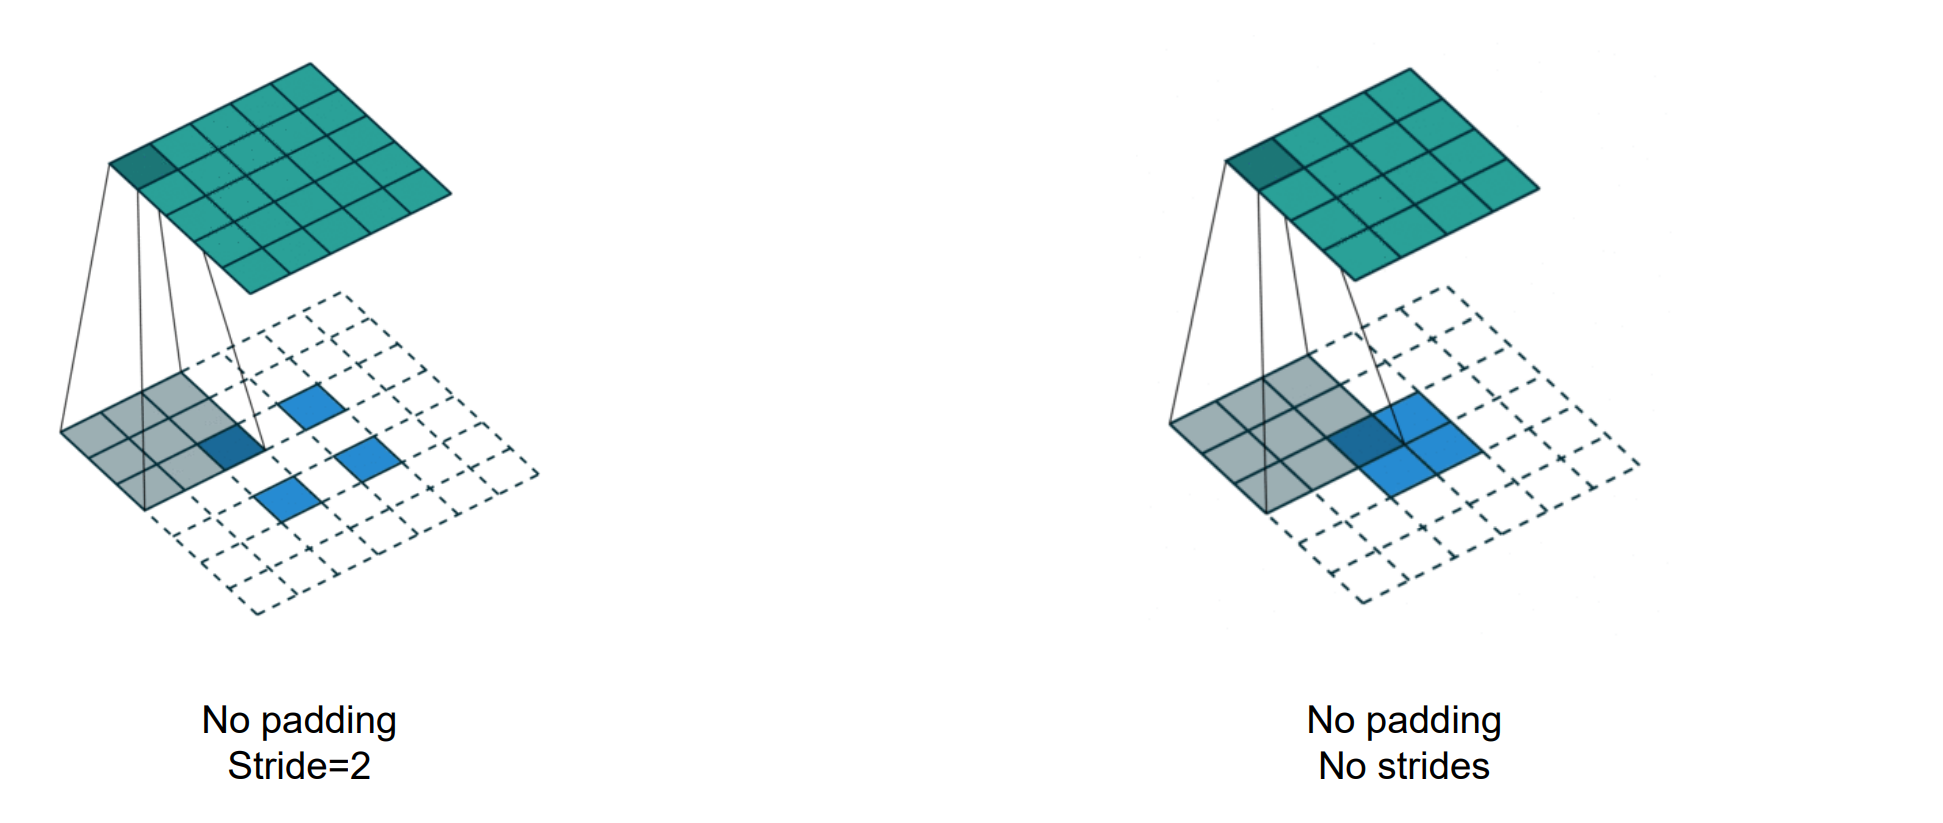

In [8]:
?torch.nn.ConvTranspose2d

```python
torch.nn.ConvTranspose2d(
    in_channels, out_channels, kernel_size, stride=1,
    padding=0, output_padding=0, groups=1, bias=True,
    dilation=1, padding_mode='zeros', device=None,
    dtype=None
)
```

In [10]:
upconv = torch.nn.ConvTranspose2d(1, 1, 3)
ex = torch.randint(0, 100, (2,2)).view(1, 1, 2, 2).float()
ex

tensor([[[[61., 18.],
          [69., 52.]]]])

In [13]:
upconv(ex)

tensor([[[[  3.6571,  -4.8990, -12.8239,  -3.2655],
          [ 19.9411,  11.1477, -30.8483, -14.2186],
          [ 16.1710,  43.8127,  15.1612,  -8.1827],
          [ -1.9291,  20.4787,  38.2100,  16.3385]]]],
       grad_fn=<ConvolutionBackward0>)

## `U-Net`

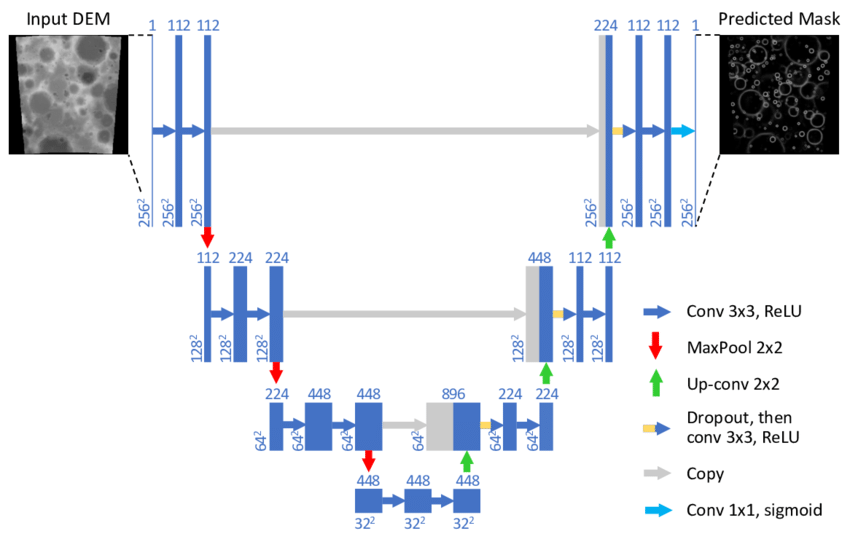

## `LinkNet`

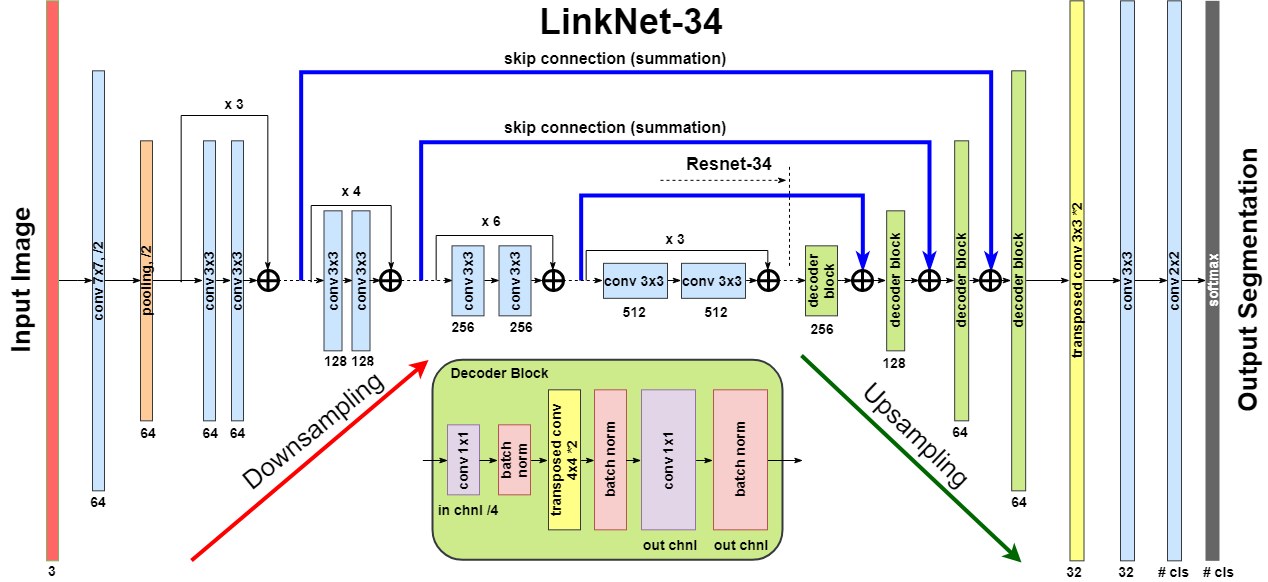

In [14]:
import utils

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Normalize

import tqdm.notebook as tqdm

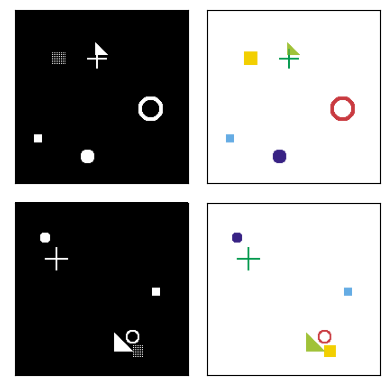

In [11]:
input_images, target_masks = utils.generate_random_data(192, 192, count=2)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]
# Map each channel (i.e. class) to each color
target_masks_rgb = [utils.masks_to_colorimg(x) for x in target_masks]
# Left: Input image (black and white), Right: Target mask (6ch)
utils.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [12]:
input_images, target_masks = utils.generate_random_data(192, 192, count=2)
input_images.shape, target_masks.shape

((2, 192, 192, 3), (2, 6, 192, 192))

In [13]:
input_images.max(), target_masks.max()

(255, 1.0)

## `Датасет`

In [29]:
class ShapeDataset(Dataset):
    def __init__(
        self, n_images=2000, width=224, height=224, transforms=None
    ):
        super().__init__()
        
        self.X, self.y = utils.generate_random_data(
            width=width, height=height, count=n_images
        )
        self.transform = transforms
        
    def __getitem__(self, idx):
        image = self.X[idx]
        image = (image / 255).astype('float32')
        image = torch.from_numpy(image).permute(2, 0, 1)
        
        mask = self.y[idx]
        mask = torch.from_numpy(mask)
        if self.transform is not None:
            image = self.transform(image)
        return image, mask
    
    def __len__(self):
        return self.X.shape[0]

In [102]:
transforms = Compose([
    Normalize(
        (0.485, 0.456, 0.406), 
        (0.229, 0.224, 0.225))
])
dataset = ShapeDataset(n_images=10, transforms=transforms)

In [45]:
image, mask = dataset[5]

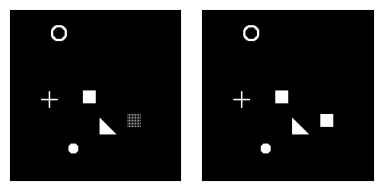

In [46]:
with mpl.rc_context({'image.cmap': 'gray'}):
    utils.plot_side_by_side([[image.numpy()[0]], [np.max(mask.numpy(), axis=0)]])

## `Нейронная сеть`

### `Encoder`

![vggarc.png](https://raw.githubusercontent.com/mmp-practicum-team/mmp_practicum_spring_2022/main/Seminars/Seminar%2005/images/vggarc.png)

**Conv2d:**

![conv2d.png](https://raw.githubusercontent.com/mmp-practicum-team/mmp_practicum_spring_2022/main/Seminars/Seminar%2005/images/conv2d.png)

In [47]:
class VGGBlock(torch.nn.Module):
    def __init__(
        self, in_channels=3, out_channels=64, 
        conv_layers=2, batch_norm=True
    ):
        super().__init__()
        
        layers = []
        for _ in range(conv_layers):
            layers.append(
                torch.nn.Conv2d(
                    in_channels, out_channels, 
                    kernel_size=3, padding=1
                )
            )
            in_channels = out_channels
            if batch_norm:
                layers.append(torch.nn.BatchNorm2d(out_channels))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.block(x)
        return x

In [49]:
class VGG16(torch.nn.Module):
    def __init__(self, batch_norm=True):
        super().__init__()
        
        block_sequence = [
            VGGBlock(3, 64, 2, batch_norm),
            VGGBlock(64, 128, 2, batch_norm),
            VGGBlock(128, 256, 3, batch_norm),
            VGGBlock(256, 512, 3, batch_norm), 
            VGGBlock(512, 512, 3, batch_norm)
        ]
        self.block_sequence = torch.nn.Sequential(*block_sequence)
    def forward(self, x):
        x = self.block_sequence(x)
        return x

In [51]:
VGG16()

VGG16(
  (block_sequence): Sequential(
    (0): VGGBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): VGGBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Re

### `Full model`

![encdec1.png](https://raw.githubusercontent.com/mmp-practicum-team/mmp_practicum_spring_2022/main/Seminars/Seminar%2005/images/encdec1.png)

**ConvTransposed2d:**
![transposed.png](https://raw.githubusercontent.com/mmp-practicum-team/mmp_practicum_spring_2022/main/Seminars/Seminar%2005/images/transposed.png)

In [140]:
class FCN32(torch.nn.Module):
    def __init__(self, encoder, n_class):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Sequential(
                torch.nn.ConvTranspose2d(
                    512, 512, kernel_size=3,
                    stride=2, padding=1, output_padding=1
                ), 
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(512)
            ),
            torch.nn.Sequential(
                torch.nn.ConvTranspose2d(
                    512, 256, kernel_size=3,
                    stride=2, padding=1, output_padding=1
                ), 
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(256)
            ),
            torch.nn.Sequential(
                torch.nn.ConvTranspose2d(
                    256, 128, kernel_size=3,
                    stride=2, padding=1, output_padding=1
                ), 
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(128)
            ),
            torch.nn.Sequential(
                torch.nn.ConvTranspose2d(
                    128, 64, kernel_size=3,
                    stride=2, padding=1, output_padding=1
                ), 
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(64)
            ),
            torch.nn.Sequential(
                torch.nn.ConvTranspose2d(
                    64, 32, kernel_size=3,
                    stride=2, padding=1, output_padding=1
                ), 
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(32)
            )
        )
        
        self.classifier = torch.nn.Conv2d(32, n_class, kernel_size=1)
        
    def forward(self, x):
#         x = self.encoder(x)
        activations = []
        for block in self.encoder.block_sequence:
            x = block(x)
            activations.append(x)
        
#         x = self.decoder(x)
        for activation, block in zip(activations[::-1], self.decoder):
            x = block(activation + x)
        
        x = self.classifier(x)
        return x

## `Параметры`

In [141]:
num_epoch = 50
batch_size = 20
lr = 1e-4
weight_decay = 1e-4

n_train = 2000
n_val = 500

n_class = 6
step_size = 50
gamma = 0.5

## `Загрузчики данных`

In [103]:
train_set = ShapeDataset(n_images=n_train, transforms=transforms)
val_set = ShapeDataset(n_images=n_val, transforms=transforms)
train_dataloder = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloder = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

## `Модель`

In [142]:
vgg16 = VGG16()
model = FCN32(encoder=vgg16, n_class=n_class)
model

FCN32(
  (encoder): VGG16(
    (block_sequence): Sequential(
      (0): VGGBlock(
        (block): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
          (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (1): VGGBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0

In [143]:
images, _ = next(iter(train_dataloder))
images.shape

torch.Size([20, 3, 224, 224])

In [146]:
from torchviz import make_dot

In [149]:
output = model(images)
loss = torch.mean(output)

make_dot(loss, params=model.state_dict()).render("model", format="svg")

'model.svg'

In [145]:
output.shape

torch.Size([20, 6, 224, 224])

## `Функция потерь, оптимизатор, ...`

In [66]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## `Train & validation loops`

In [67]:
def val(epoch, model):
    model.eval()
    model = model.to(device)
    
    total_loss, n = 0.0, 0
    with torch.no_grad():
        loss_stat = []
        for inputs, labels in val_dataloder:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            n += outputs.shape[0]
            total_loss += loss.item() * outputs.shape[0]
            
    print(f'Loss for epoch {epoch}: {total_loss / n}')

In [68]:
def train(model):
    model = model.to(device)
    
    for epoch in tqdm.tqdm(range(num_epoch), total=num_epoch):
        model.train()
        for inputs, labels in train_dataloder:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        val(epoch, model)
        
    torch.save(model.state_dict(), 'model.pth')

In [69]:
train(model)

  0%|          | 0/50 [00:00<?, ?it/s]

Loss for epoch 0: 0.6644272375106811
Loss for epoch 1: 0.6488807463645935
Loss for epoch 2: 0.622491888999939
Loss for epoch 3: 0.59943284034729
Loss for epoch 4: 0.5636993956565857
Loss for epoch 5: 0.5261664080619812
Loss for epoch 6: 0.48927462100982666
Loss for epoch 7: 0.4450883626937866
Loss for epoch 8: 0.40611645340919494
Loss for epoch 9: 0.3674655020236969
Loss for epoch 10: 0.32692265152931216
Loss for epoch 11: 0.29277063846588136
Loss for epoch 12: 0.2602220153808594
Loss for epoch 13: 0.2328067684173584
Loss for epoch 14: 0.20535473883152008
Loss for epoch 15: 0.18214236617088317
Loss for epoch 16: 0.16252090632915497
Loss for epoch 17: 0.14411522269248964
Loss for epoch 18: 0.13030322909355163
Loss for epoch 19: 0.1163539418578148
Loss for epoch 20: 0.10374043315649033
Loss for epoch 21: 0.0917273160815239
Loss for epoch 22: 0.0870222344994545
Loss for epoch 23: 0.07462226927280426
Loss for epoch 24: 0.06810052126646042
Loss for epoch 25: 0.06096022441983223
Loss for epo

In [73]:
data = model.state_dict()

In [75]:
model.load_state_dict(data)

<All keys matched successfully>

In [76]:
torch.save(data, 'model.pth')

In [77]:
data = torch.load('model.pth')

In [78]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [79]:
inverse_transforms = Compose([
    Normalize(
        (-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225), 
        (1.0 / 0.229, 1.0 / 0.224, 1.0 / 0.225))
])

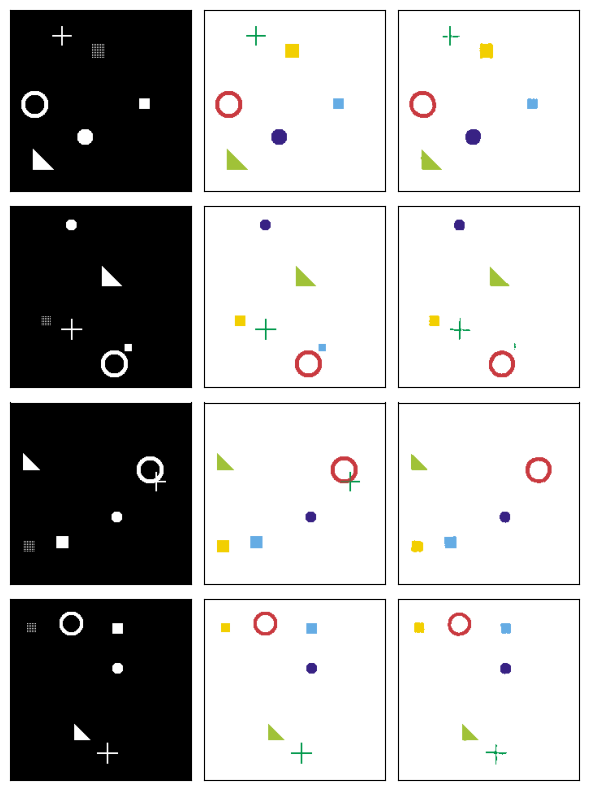

In [80]:
model.eval()   

inputs, labels = next(iter(val_dataloder))
inputs = inputs.to(device)[:4]
labels = labels.to(device)[:4]

pred = model(inputs)

pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()

input_images_rgb = [inverse_transforms(x).permute(1, 2, 0) for x in inputs.cpu()]

target_masks_rgb = [utils.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [utils.masks_to_colorimg(x) for x in pred]

utils.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

## `Как использовать предобученную сеть из torch.hub`

In [81]:
?torch.hub.load

Загрузим сеть [**deeplabv3+**](https://arxiv.org/pdf/1802.02611v3.pdf):

In [82]:
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

In [83]:
model = torch.hub.load(
    'pytorch/vision:v0.10.0', 'deeplabv3_resnet50', 
    weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /home/maksim64/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /home/maksim64/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 161M/161M [00:03<00:00, 48.3MB/s]


In [84]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [85]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [86]:
from PIL import Image
from torchvision import transforms

# откроем картинку из интернета
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) 

model.to(device)
model.eval()
with torch.no_grad():
    input_batch = input_batch.to(device)
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)
output_predictions

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

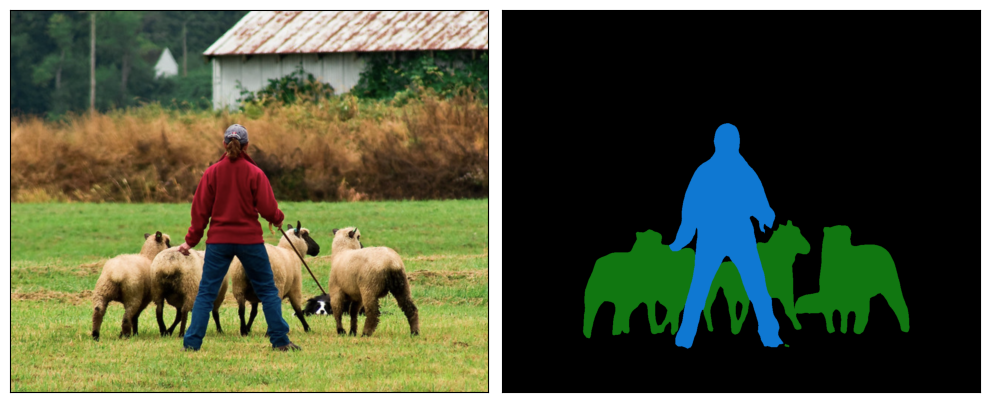

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# create a color pallette, selecting a color for each class
palette = np.array([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = np.arange(21)[:, None]* palette
colors = (colors % 255).astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
image_mask = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
image_mask.putpalette(colors)

for ax, image in zip(axes.reshape(-1), [input_image, image_mask]):
    ax.imshow(image)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()